# 1. Configuração do Ambiente e Importação das Bibliotecas

In [14]:
import pandas as pd
import numpy as np
import io
import re
import ast
from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("Bibliotecas importadas com sucesso.")

Bibliotecas importadas com sucesso.


# 2. Carregamento dos Dados

In [15]:
def carregar_dados_do_colab(nome_arquivo):

    print(f"Por favor, faça o upload do arquivo: {nome_arquivo}")

    try:
        uploaded = files.upload()

        if nome_arquivo not in uploaded:
            print(f"\nErro: O arquivo '{nome_arquivo}' não foi encontrado.")
            return None

        arquivo_bytes = uploaded[nome_arquivo]
        df = None
        separadores_para_tentar = [';', ',', '\t']

        for sep in separadores_para_tentar:
            try:
                print(f"Tentando ler o arquivo com o separador: '{sep}'")
                df = pd.read_csv(io.BytesIO(arquivo_bytes), sep=sep)

                if df.shape[1] > 1:
                    print(f"Sucesso! O separador correto é '{sep}'.")
                    break
            except Exception:
                print(f"Falha ao usar o separador '{sep}'. Tentando o próximo.")
                df = None

        if df is None or df.shape[1] <= 1:
             print("\nNão foi possível determinar o separador correto automaticamente.")
             return None

        print(f"\nArquivo '{nome_arquivo}' carregado com sucesso!")
        print(f"Dimensões do DataFrame: {df.shape[0]} linhas e {df.shape[1]} colunas.")
        return df

    except Exception as e:
        print(f"\nOcorreu um erro inesperado durante o processo: {e}")
        return None

NOME_ARQUIVO_CSV = 'ml_produtos_hp_final_features_target.csv'

df_raw = carregar_dados_do_colab(NOME_ARQUIVO_CSV)

if df_raw is not None:
    print("\nAbaixo estão as 5 primeiras linhas do DataFrame carregado:")
    display(df_raw.head())

Por favor, faça o upload do arquivo: ml_produtos_hp_final_features_target.csv


Saving ml_produtos_hp_final_features_target.csv to ml_produtos_hp_final_features_target.csv
Tentando ler o arquivo com o separador: ';'
Sucesso! O separador correto é ';'.

Arquivo 'ml_produtos_hp_final_features_target.csv' carregado com sucesso!
Dimensões do DataFrame: 38 linhas e 22 colunas.

Abaixo estão as 5 primeiras linhas do DataFrame carregado:


,link_anuncio,titulo,preco,vendedor,avaliacao_nota,avaliacao_numero,descricao,marca,modelo,cor,...,rendimento_paginas,impressoras_compativeis,volume_ml_ou_peso_g,estado_produto,nota_qualidade,justificativa_qualidade,seller_trust_level,preco_medio_categoria,desvio_preco_media_categoria,label_heuristico_calculado
0,https://www.mercadolivre.com.br/kit-cartucho-h...,Kit Cartucho Hp 664 Preto E Hp 664 Colorido,"153,1",OBERO INFORMATICA,"4,7",3086,Descrição KIT DE CARTUCHOS DE TINTA HP ORIGINA...,HP,664,"['Preto', 'Colorido']",...,Até 120 páginas,"['HP DeskJet 1110', 'HP DeskJet 1115', 'HP Des...",NaN,Novo,4,Boa descrição com informações relevantes. Pequ...,3,"127,4814705882353","0,20095884753724294",original
1,https://www.mercadolivre.com.br/cartucho-de-ti...,Cartucho de tinta preta HP Advantage 664 de 2 ml,"64,9",OBERO INFORMATICA,"4,7",3086,Descrição Imprima documentos do dia a dia com ...,HP,NaN,Preto,...,120 páginas,"['HP DeskJet 1110', 'HP DeskJet 1115', 'HP Des...",NaN,NaN,3,"Informações essenciais presentes, mas organiza...",3,"127,4814705882353","-0,4909064062366618",avaliar_manual_orig_desconhecida_vendedor_conf...
2,https://www.mercadolivre.com.br/cartucho-de-ti...,Cartucho De Tinta Hp 664 Negro y 664 Tricolor ...,"153,1",OBERO INFORMATICA,"4,6",267,Descrição Kit de cartuchos de tinta HP origina...,HP,664,"['Preto', 'Colorido']",...,até 120 páginas,"['HP DeskJet 1110', 'HP DeskJet 1115', 'HP Des...",NaN,Novo,3,"Informação completa, porém com formatação conf...",3,"127,4814705882353","0,20095884753724294",original
3,https://www.mercadolivre.com.br/cartucho-de-ti...,Cartucho de Tinta HP 122 Preto,"102,19",OBERO INFORMATICA,"4,8",106,Descrição Cartucho de Tinta HP 122 Preto Origi...,HP,122,Preto,...,120 páginas,"['HP Deskjet 1000 - J110a', 'HP Deskjet 2000 -...",2 ML,NaN,4,"Descrição clara, completa e profissional, com ...",3,"127,4814705882353","-0,19839330744721842",original
4,https://produto.mercadolivre.com.br/MLB-268503...,Kit Cartucho Tinta Original Hp 667 Preto/color...,"154,9",OBERO INFORMATICA,"4,7",3657,Descrição ***REVENDEDOR OFICIAL HP BRASIL*** O...,HP,667,"['Preto', 'Colorido']",...,até 100 páginas,"['Deskjet Ink Advantage 2300', 'Deskjet Ink Ad...",2ml,Novo,3,"Informação razoável, mas falta a cor do cartuc...",3,"127,4814705882353","0,21507854659385334",original


# 3. Limpeza e Transformação dos Dados

In [16]:
def limpar_e_transformar_dados(df):

    df_clean = df.copy()

    for col in ['preco', 'avaliacao_nota', 'preco_medio_categoria', 'desvio_preco_media_categoria']:
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].str.replace(',', '.', regex=False).astype(float)

    for col in ['avaliacao_numero', 'nota_qualidade', 'seller_trust_level']:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0).astype(int)

    def extrair_numero(texto):
        if isinstance(texto, str):
            numeros = re.findall(r'\d+\.?\d*', texto)
            return float(numeros[0]) if numeros else np.nan
        return np.nan

    df_clean['rendimento_paginas_num'] = df_clean['rendimento_paginas'].apply(extrair_numero)
    df_clean['volume_num'] = df_clean['volume_ml_ou_peso_g'].apply(extrair_numero)

    def converter_string_para_lista(s):
        try:
            return ast.literal_eval(s)
        except (ValueError, SyntaxError, TypeError):
            return [s] if isinstance(s, str) else []

    df_clean['cor'] = df_clean['cor'].apply(converter_string_para_lista)
    df_clean['impressoras_compativeis'] = df_clean['impressoras_compativeis'].apply(converter_string_para_lista)

    df_clean['modelo'] = df_clean['modelo'].fillna('Não informado')

    print("Limpeza e transformação concluídas.")
    return df_clean

df_clean = limpar_e_transformar_dados(df_raw)

df_clean.info()

Limpeza e transformação concluídas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   link_anuncio                  38 non-null     object 
 1   titulo                        38 non-null     object 
 2   preco                         38 non-null     float64
 3   vendedor                      38 non-null     object 
 4   avaliacao_nota                38 non-null     float64
 5   avaliacao_numero              38 non-null     int64  
 6   descricao                     38 non-null     object 
 7   marca                         36 non-null     object 
 8   modelo                        38 non-null     object 
 9   cor                           38 non-null     object 
 10  tipo_cartucho                 38 non-null     object 
 11  originalidade                 23 non-null     object 
 12  rendimento_paginas            

# 4. Análise Exploratória de Dados (EDA)

## 4.1. Análise Descritiva Geral

In [17]:
df_clean.describe()

,preco,avaliacao_nota,avaliacao_numero,nota_qualidade,seller_trust_level,preco_medio_categoria,desvio_preco_media_categoria,rendimento_paginas_num,volume_num
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,3.800000e+01,30.000000,25.000000
mean,118.313158,4.678947,809.789474,3.368421,1.815789,118.313158,-2.921640e-17,154.433333,23.040000
std,74.402793,0.156236,1261.793000,0.541322,0.982420,27.088803,5.452513e-01,151.112354,65.546726
min,32.830000,4.300000,2.000000,2.000000,1.000000,40.382500,-6.762667e-01,1.000000,2.000000
25%,64.390000,4.600000,53.000000,3.000000,1.000000,127.481471,-4.647065e-01,100.000000,2.000000
50%,108.860000,4.700000,109.500000,3.000000,1.000000,127.481471,-2.290596e-03,120.000000,2.000000
75%,157.165000,4.700000,900.250000,4.000000,3.000000,127.481471,2.328458e-01,120.000000,6.000000
max,419.000000,5.000000,3657.000000,4.000000,3.000000,127.481471,2.286752e+00,750.000000,300.000000


## 4.2. Distribuição de Preços

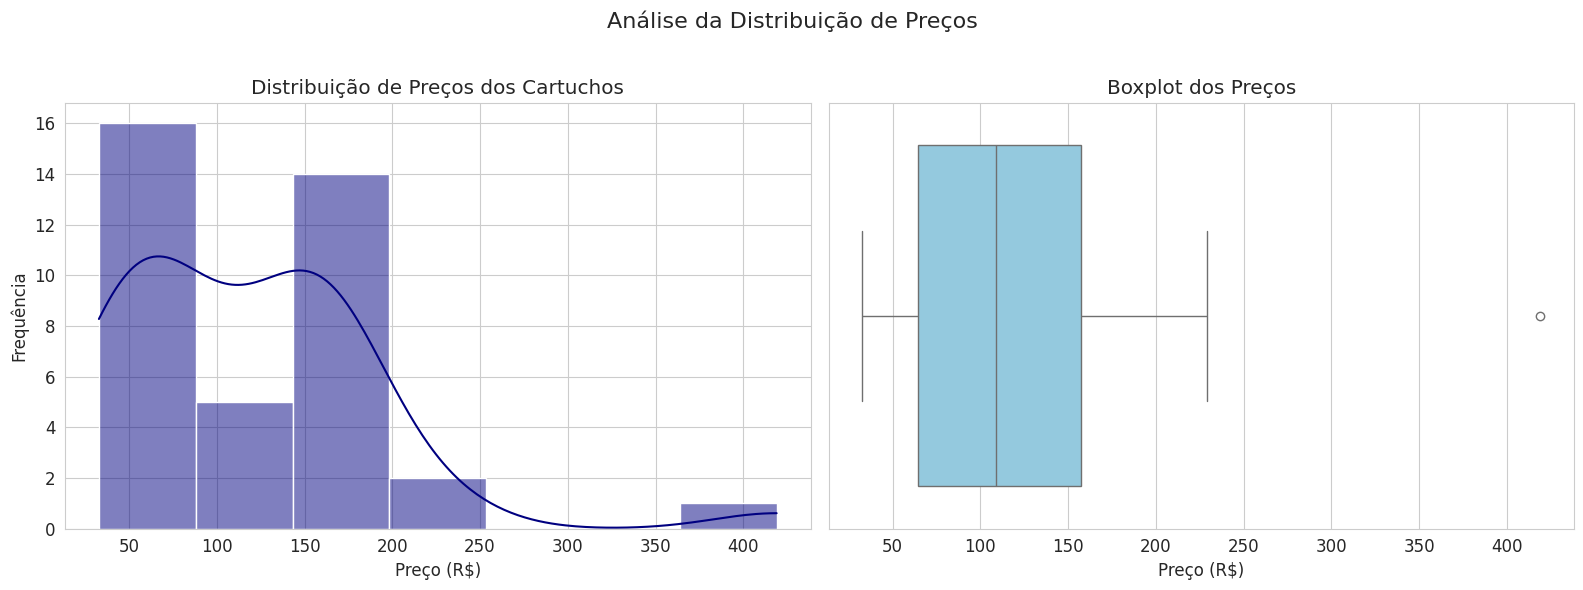

In [18]:
def plotar_distribuicao_preco(df):

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(df['preco'], kde=True, ax=axes[0], color='navy')
    axes[0].set_title('Distribuição de Preços dos Cartuchos')
    axes[0].set_xlabel('Preço (R$)')
    axes[0].set_ylabel('Frequência')

    sns.boxplot(x=df['preco'], ax=axes[1], color='skyblue')
    axes[1].set_title('Boxplot dos Preços')
    axes[1].set_xlabel('Preço (R$)')

    plt.suptitle('Análise da Distribuição de Preços', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plotar_distribuicao_preco(df_clean)

* Ao analisar a distribuição de preços, observamos dois comportamentos distintos. O histograma (à esquerda) mostra claramente dois picos de concentração de anúncios: um na faixa de 50 reais a 100 reais e outro mais expressivo entre 150 reais e 200 reais. Isso sugere que nosso dataset contém pelo menos dois grupos de produtos diferentes, cartuchos vendidos individualmente (mais baratos) e kits promocionais (preto + colorido), que possuem um valor agregado maior. O boxplot (à direita) confirma essa dispersão e destaca a presença de um outlier significativo, um produto com preço próximo a 400 reais, que pode representar um item de nicho, como cartuchos para plotters ou de altíssimo rendimento.

## 4.3. Análise dos Rótulos

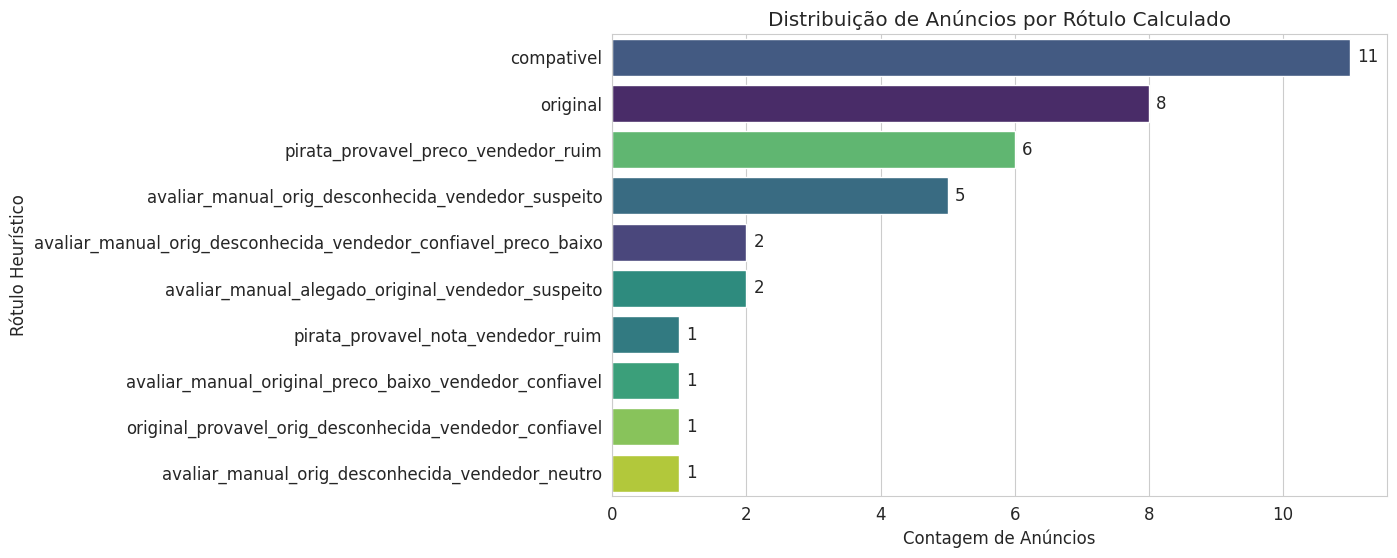

In [19]:
def plotar_distribuicao_rotulos(df):

    ordem_rotulos = df_clean['label_heuristico_calculado'].value_counts().index
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(
    data=df_clean,
    y='label_heuristico_calculado',
    order=ordem_rotulos,
    hue='label_heuristico_calculado',
    legend=False,
    palette='viridis'
)

    plt.title('Distribuição de Anúncios por Rótulo Calculado')
    plt.xlabel('Contagem de Anúncios')
    plt.ylabel('Rótulo Heurístico')

    for p in ax.patches:
        ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                    ha='left', va='center', xytext=(5, 0), textcoords='offset points')

    plt.show()

plotar_distribuicao_rotulos(df_clean)

* Este gráfico nos dá um panorama da classificação dos nossos dados. Vemos que as categorias com maior número de anúncios são compativel (11 anúncios) e original (8 anúncios), o que é ótimo, pois teremos uma base balanceada para treinar o modelo nessas duas classes principais. Além disso, é notável a quantidade de anúncios classificados em categorias que exigem uma análise mais cuidadosa, como pirata_provavel_preco_ruim e as diversas variações de avaliar_manual. A existência desses casos de "zona cinzenta" é extremamente valiosa, pois permitirá que nosso futuro modelo aprenda a identificar nuances e não apenas os casos óbvios, tornando-o mais robusto e preparado para o cenário real do marketplace.

## 4.4. Análise de Texto: Títulos e Descrições

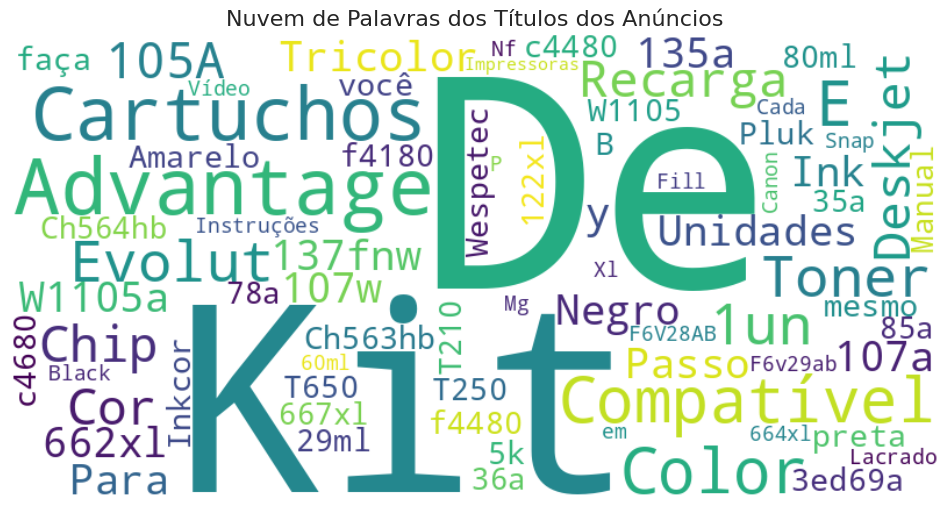

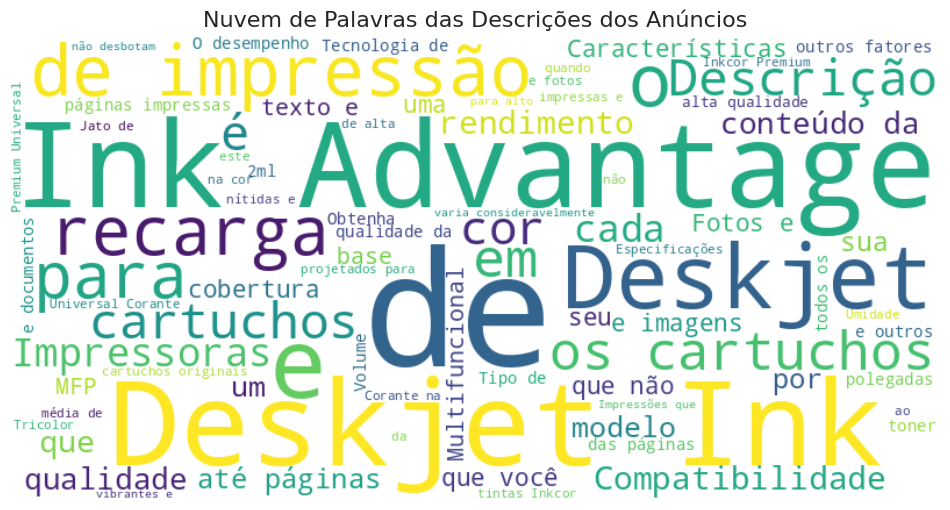

In [20]:
def gerar_wordcloud(df, coluna_texto, titulo_grafico):

    texto_completo = ' '.join(df[coluna_texto].dropna())

    stopwords = set(STOPWORDS)
    stopwords.update(['cartucho', 'tinta', 'hp', 'preto', 'colorido', 'original',
                      'impressora', 'compativel', 'paginas', 'ml', 'descricao', 'produto'])

    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          stopwords=stopwords,
                          min_font_size=10).generate(texto_completo)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo_grafico, fontsize=16)
    plt.show()

gerar_wordcloud(df_clean, 'titulo', 'Nuvem de Palavras dos Títulos dos Anúncios')

gerar_wordcloud(df_clean, 'descricao', 'Nuvem de Palavras das Descrições dos Anúncios')

A nuvem de palavras, gerada a partir das descrições dos anúncios, revela o foco da comunicação dos vendedores. Termos como Deskjet, Ink e Advantage confirmam que estamos no ecossistema correto de produtos HP. As palavras mais destacadas, como impressão, qualidade e rendimento, mostram que os argumentos de venda são centrados na performance e confiabilidade. Um achado particularmente interessante é a proeminência da palavra recarga, o que sugere fortemente que o mercado de produtos compatíveis e recarregados é relevante em nossa base, mesmo que os títulos não mencionem isso diretamente. Esta é uma evidência crucial que justifica a importância do nosso projeto de classificação.

## 4.5. Matriz de Correlação

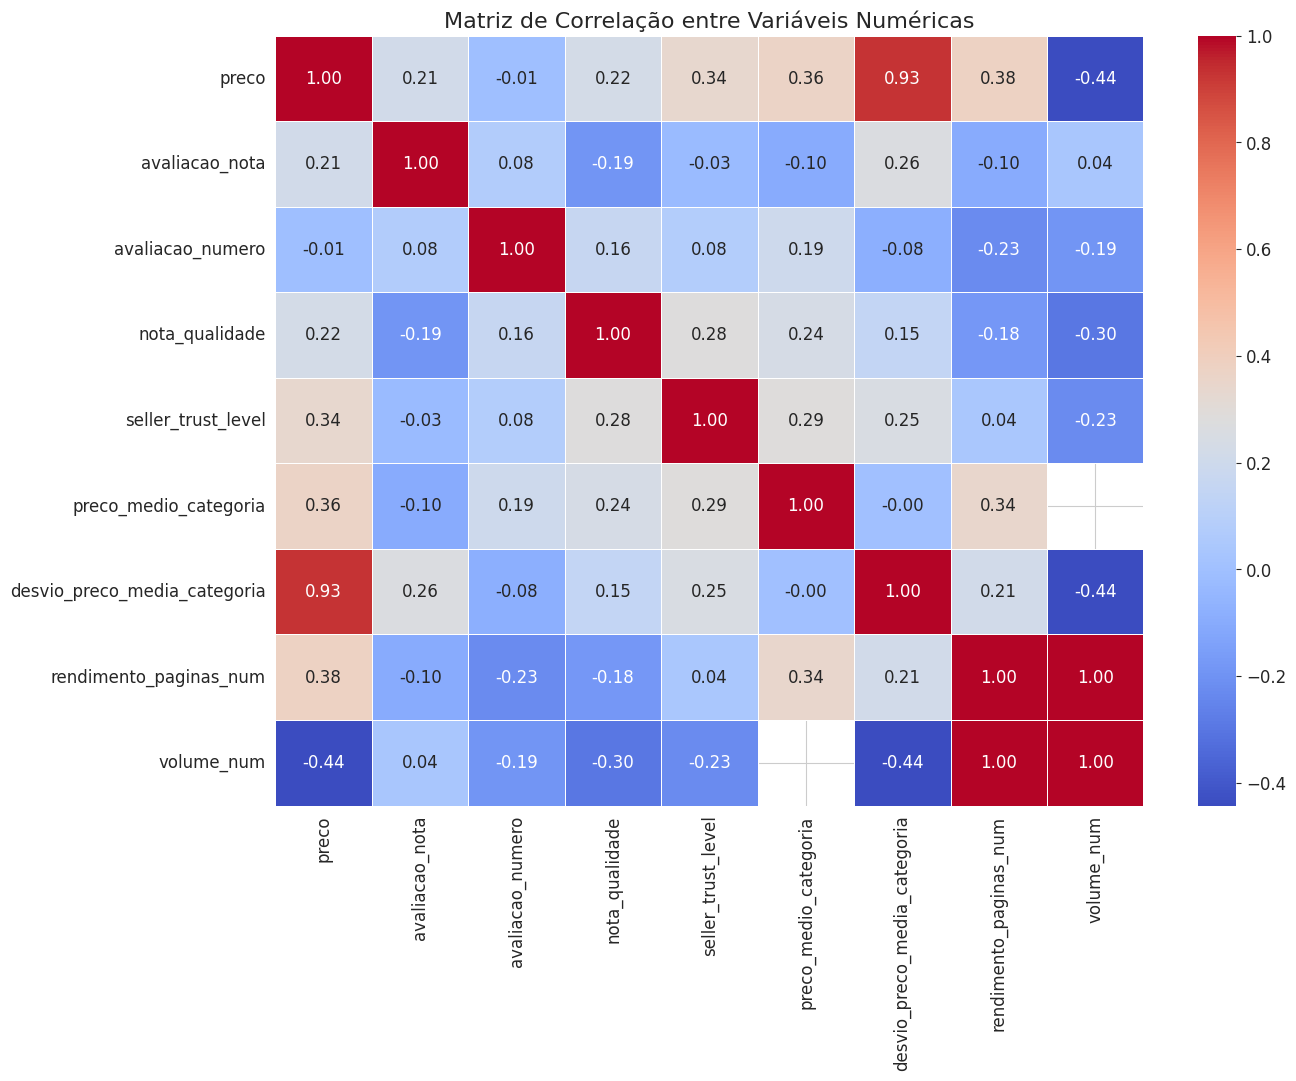

In [21]:
def plotar_matriz_correlacao(df):
    """
    Calcula e plota a matriz de correlação das variáveis numéricas.
    """
    # Selecionar apenas colunas numéricas para a correlação
    df_numeric = df.select_dtypes(include=np.number)

    # Calcular a matriz de correlação
    correlation_matrix = df_numeric.corr()

    # Criar o heatmap
    plt.figure(figsize=(14, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('Matriz de Correlação entre Variáveis Numéricas', fontsize=16)
    plt.show()

plotar_matriz_correlacao(df_clean)

A matriz de correlação nos permitiu identificar as relações lineares entre as variáveis numéricas. O principal destaque é a correlação positiva quase perfeita (+0.93) entre preco e desvio_preco_media_categoria, o que era esperado, já que a segunda variável é derivada da primeira; isso indica que deveremos usar apenas uma delas na modelagem para evitar redundância. Identificamos também uma correlação positiva moderada (+0.38) entre preco e rendimento_paginas_num, confirmando que produtos com maior rendimento tendem a ser mais caros. O ponto mais crítico levantado por este gráfico foi a correlação negativa e inesperada (-0.44) entre preco e volume_num, o que sugere um problema na coleta ou preenchimento desses dados, exigindo uma investigação mais aprofundada antes da modelagem.

# 5. Possíveis Features para a Modelagem

Com base na análise exploratória realizada, identificamos um conjunto promissor de features (características) que podem ser utilizadas para treinar nosso modelo de classificação. Elas se dividem em diferentes categorias:

## Features Numéricas Diretas:

* preco: Variável fundamental, embora possa ser substituída pelo seu desvio.

* desvio_preco_media_categoria: Feature muito poderosa, pois já contextualiza o preço do anúncio em relação aos seus concorrentes.

* avaliacao_nota: A nota média pode ser um indicador de qualidade percebida pelo cliente.

* avaliacao_numero: O número de avaliações pode indicar a popularidade ou o tempo de vida de um anúncio.

* rendimento_paginas_num: Feature lógica que relaciona o custo-benefício do cartucho.

## Features Derivadas de Texto (Engenharia de Features):

* Presença de Palavras-Chave no Título:
 * tem_kit: Variável binária (1 se "kit" estiver no título, 0 caso contrário).
 * tem_xl: Variável binária (1 se "xl" ou "alto rendimento" for mencionado, 0 caso contrário).
 * tem_compativel: Variável binária (1 se "compatível", "para", "tipo" estiverem no título).
* Presença de Palavras-Chave na Descrição:
  * menciona_recarga: Variável binária (1 se "recarga", "recarregável" aparecer na descrição).
  * menciona_garantia: Variável binária (1 se "garantia" for mencionada).
* Características da Descrição:
  * comprimento_descricao: O tamanho da descrição pode indicar o nível de detalhe (e talvez o profissionalismo) do vendedor.

## Features Categóricas:

* modelo: O modelo do cartucho (ex: 664, 667) é uma das informações mais importantes e deve ser tratada (possivelmente com one-hot encoding).
* estado_produto: A distinção entre "Novo" e "Usado" é fundamental.

# 6. Features a serem Reavaliadas:

* volume_num: Devido à correlação negativa inesperada, esta feature precisa ser corrigida ou descartada. Uma alternativa seria criar a feature volume_informado (sim/não).